The mean field $\alpha - \Omega $ dynamo equation in the kinematic regime,

$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}=  -\frac{\partial \alpha \bar{B}_\phi}{\partial z}+\eta_T\left( \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right]+ \frac{\partial^2 \bar{B}_r}{\partial z^2}\right), \\
& \frac{\partial \bar{B}_\phi}{\partial t}= -q\Omega \bar{B}_r+\eta_T \left(\frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] +\frac{\partial^2 \bar{B}_\phi}{\partial z^2}\right)\\
\end{aligned}
\end{aligned}
$$

Applying the no-z approximation,

$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= - \frac{2}{\pi h}\alpha \bar{B}_\phi+\eta_T\left( \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] -  \frac{\pi^2}{4h^2} \bar{B}_r\right) , \\
& \frac{\partial \bar{B}_\phi}{\partial t}=r \frac{\partial\Omega}{\partial r}\bar{B}_r+\eta_T \left(\frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \frac{\pi^2}{4h^2} \bar{B}_\phi \right)\\
\end{aligned}
\end{aligned}
$$

Next, apply the model for disk flaring. $h$ is no longer a constant, it is now a function of radius $r$.

Model A:
$$h = h_0 \exp\left(\frac{r}{r_h}\right)$$

Finally, make them dimensionless to obtain the final equations to be solved,
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}=- \frac{2}{\pi}\,\alpha\bar{B}_\phi \exp\left({-\frac{r}{r_h}}\right) + \left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] - \frac{\pi^2 }{4}\bar{B}_r \exp\left(-\frac{2r}{r_h}\right), \\
& \frac{\partial \bar{B}_\phi}{\partial t}= r \frac{\partial\Omega}{\partial r}\bar{B}_r+\left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \frac{\pi^2 }{4}\bar{B}_\phi \exp\left(-\frac{2r}{r_h}\right)\\
\end{aligned}
\end{aligned}
$$




# Boundary Conditions
$$
B_r(0)= 0 =Br(R_0)\\

B_\phi(0)=0 = B_\phi(R_0)\\
$$

In [15]:
#Preliminaries and definitions

import numpy as np

#Grid
rmax=2.1

N_r=400
dr=rmax/(N_r-1)
r=np.linspace(0.001, rmax, N_r)


#Typical lengthscales
h0=0.5 #kpc
R0=15 #kpc
r_omeg = 2 #kpc
l = 0.1 #kpc
r_aitch = 2.1*R0 #kpc
r_h = r_aitch/R0
h = h0*np.exp(r/r_h)


#Seed field
freq = 2  #Frequency of the sinusoidal function
amplitude = 1  # Amplitude of the sinusoidal function
noise_level = 0.2  # Level of random noise to add

# Different possible seed functions, choose a sine function
rand_sinfunc = amplitude * np.sin(2 * np.pi * freq * r) #+ np.random.normal(scale=noise_level, size=N_r)
rand_cosfunc = amplitude * np.cos(2 * np.pi * freq * r) #+ np.random.normal(scale=noise_level, size=N_r)

Br = np.sin(r/rmax * np.pi)
Bphi = -np.cos(r/rmax * np.pi)

#Timesteps
tmax=80
N_t=10000
dt=tmax/N_t
tarray = np.linspace(0,tmax,N_t)

#Dimensionless Omega and alpha
Omega0=40
Omega = Omega0/np.sqrt(1 + (r*R0/r_omeg)**2)

#alpha0 = [2,2.4,2.5,2.6]
alpha0 = l**2/(h*h0) * Omega

#Define spatial derivatives
def cyl_laplacian_r(Bi):
    return (h0/R0)**2*np.gradient(np.gradient(r*Bi,dr)/r,dr)

def delrOmega(Omega):
    return np.gradient(Omega,dr)

#Define equations
def eqn_Br(Br,Bphi,alpha):
    return -2 * alpha / np.pi * Bphi * np.exp(-r/r_h) + cyl_laplacian_r(Br) - np.pi**2/4 * Br * np.exp(-2*r/r_h)


def eqn_Bphi(Br,Bphi,Omega):
    return r * delrOmega(Omega) * Br + cyl_laplacian_r(Bphi) - np.pi**2/4 * Bphi * np.exp(-2*r/r_h)

#Define RK4
def RK4(dt,alpha,Br,Bphi):
    k1r = dt*eqn_Br(Br, Bphi, alpha)
    k1phi = dt*eqn_Bphi(Br, Bphi, Omega)

    k2r = dt*eqn_Br(Br+k1r/2, Bphi+k1phi/2, alpha)
    k2phi = dt*eqn_Bphi(Br+k1r/2, Bphi+k1phi/2, Omega)

    k3r = dt*eqn_Br(Br+k2r/2, Bphi+k2phi/2, alpha)
    k3phi = dt*eqn_Bphi(Br+k2r/2, Bphi+k2phi/2, Omega)

    k4r = dt*eqn_Br(Br+k3r, Bphi+k3phi, alpha)
    k4phi = dt*eqn_Bphi(Br+k3r, Bphi+k3phi, Omega)
    
    return Br + (k1r + 2*k2r + 2*k3r + k4r)/6, Bphi + (k1phi + 2*k2phi + 2*k3phi + k4phi)/6

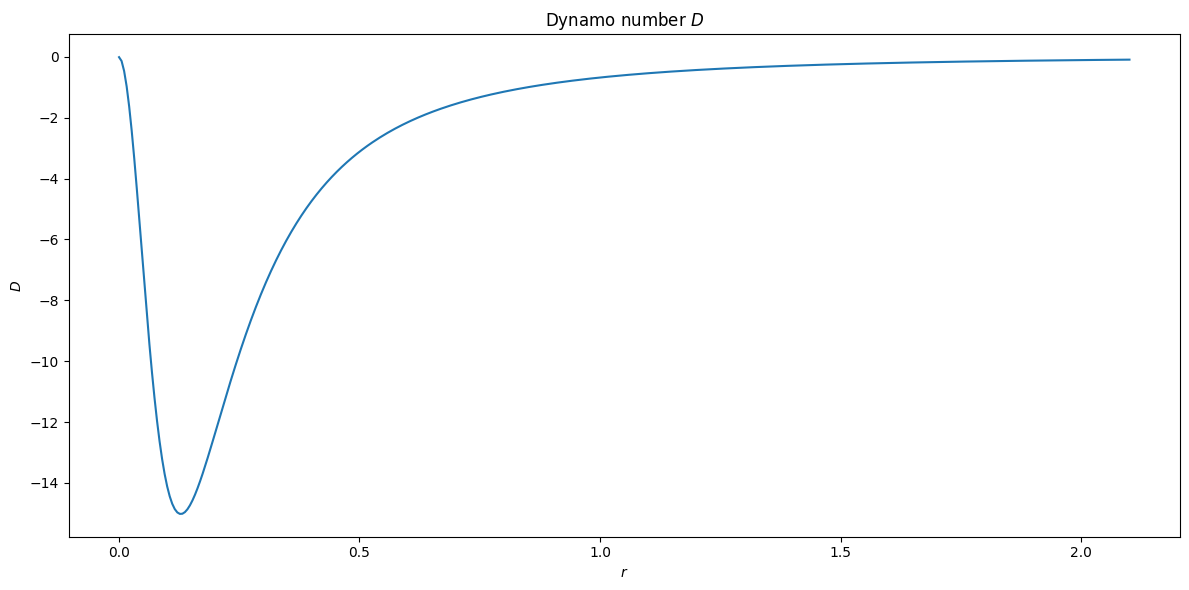

-15.015562495950633


In [16]:
D=alpha0*r*delrOmega(Omega)

import matplotlib.pyplot as plot
fig, ax = plot.subplots(figsize=(12, 6))
plot.plot(r,D)
plot.xlabel(r'$r$')
plot.ylabel(r'$D$')
plot.title(r"Dynamo number $D$")
plot.tight_layout()
plot.show()

print(np.min(D))

In [17]:
#Iterate through RK4 for different values of alpha0 (hence different values of D)

#Array to store all values
sol_array_Br=np.zeros((N_t,N_r))
sol_array_Bphi=np.zeros((N_t,N_r))

brcopy=Br
bphicopy=Bphi

for t in range(N_t):
    Br[0]=0
    Br[-1]=0
    Bphi[0]=0
    Bphi[-1]=0
    sol_array_Br[t,:]=np.copy(Br)
    sol_array_Bphi[t,:]=np.copy(Bphi)
    Br,Bphi=RK4(dt,alpha0,Br,Bphi)
Br=brcopy
Bphi=bphicopy

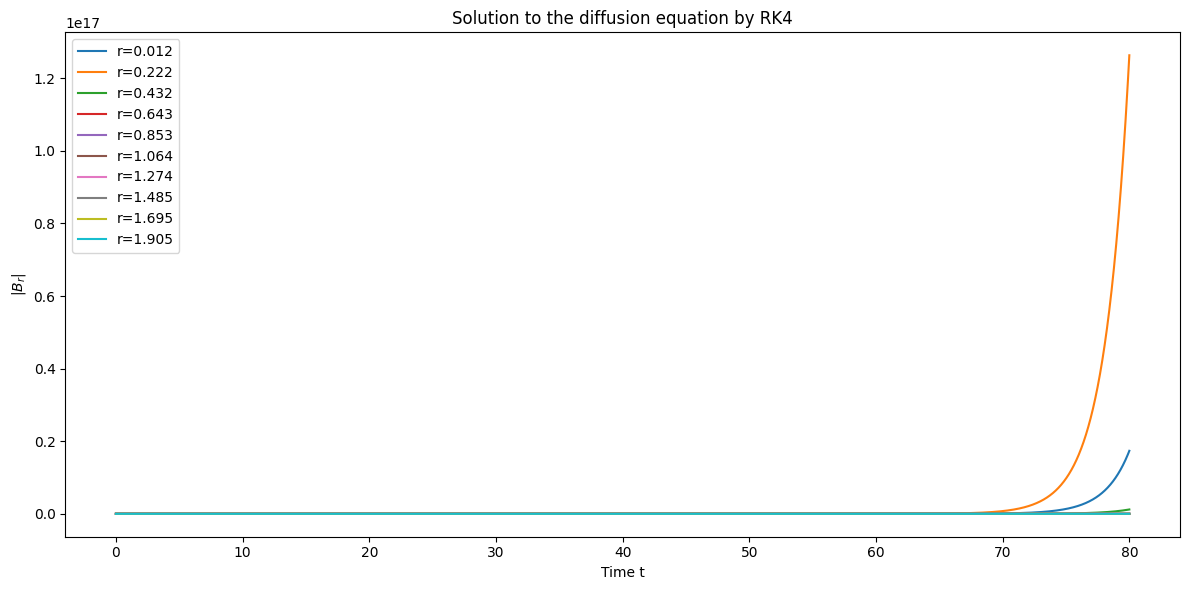

In [18]:
#Plot |B_r| vs. t


fig, ax = plot.subplots(figsize=(12, 6))
plot.plot(tarray, np.abs(sol_array_Br[:, 2::len(r)//10]))
ax.legend(labels=[f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
plot.xlabel('Time t')
plot.ylabel(r'$|B_r|$')
plot.title(r"Solution to the diffusion equation by RK4")
plot.tight_layout()
plot.show()

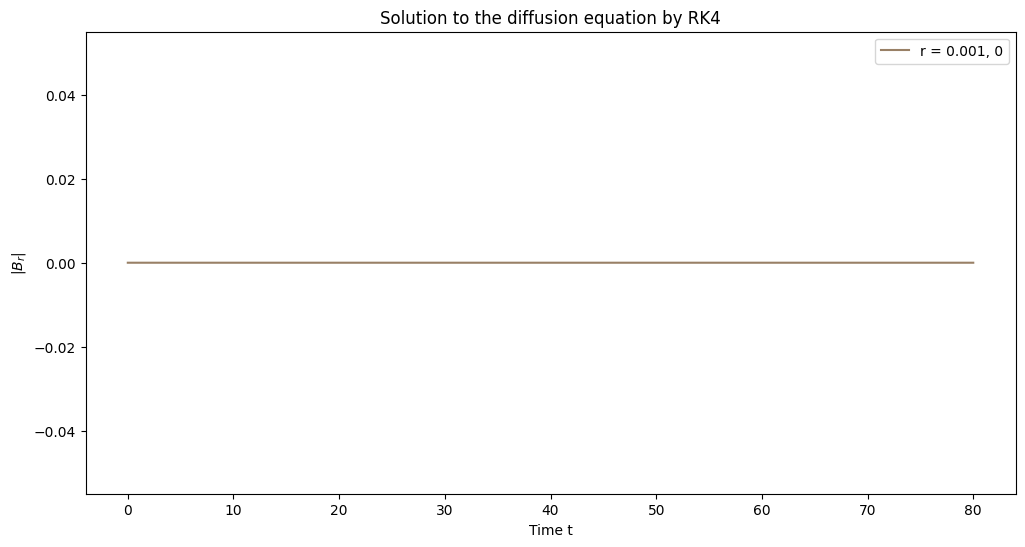

In [19]:
from matplotlib.animation import FuncAnimation
from IPython.display import display
# Animate the plot

fig, ax = plot.subplots(figsize=(12, 6))

def update_plot(frame):
    ax.clear()  # Clear the current plot
    color = np.random.rand(3,) 
    ax.plot(tarray, np.abs(sol_array_Br[:,frame]), color=color, label=f'r = {r[frame]:.3f}, {frame}')
    ax.set_xlabel('Time t')
    ax.set_ylabel(r'$|B_r|$')
    ax.set_title("Solution to the diffusion equation by RK4")
    ax.legend()

# Animate the plot
Frames = np.array([i for i in range(0,130)])
animation = FuncAnimation(fig, update_plot, frames=Frames, interval=50)
animation.save('ani2.gif')
from IPython.display import HTML
HTML(animation.to_html5_video())

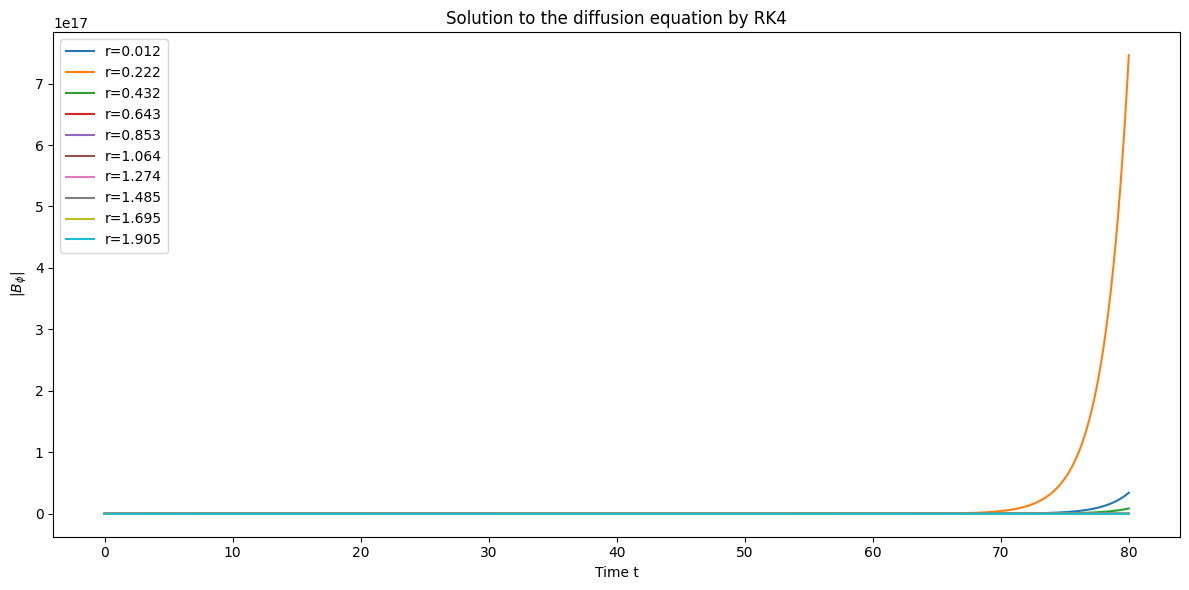

In [20]:
#Plot |B_phi| vs. t for different alpha0

plot.figure(figsize=(12, 6))
plot.plot(tarray, np.abs(sol_array_Bphi[:, 2::len(r)//10]))
plot.legend([f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
plot.xlabel('Time t')
plot.ylabel(r'$|B_\phi|$')
plot.title(r"Solution to the diffusion equation by RK4")
plot.tight_layout()
plot.show()

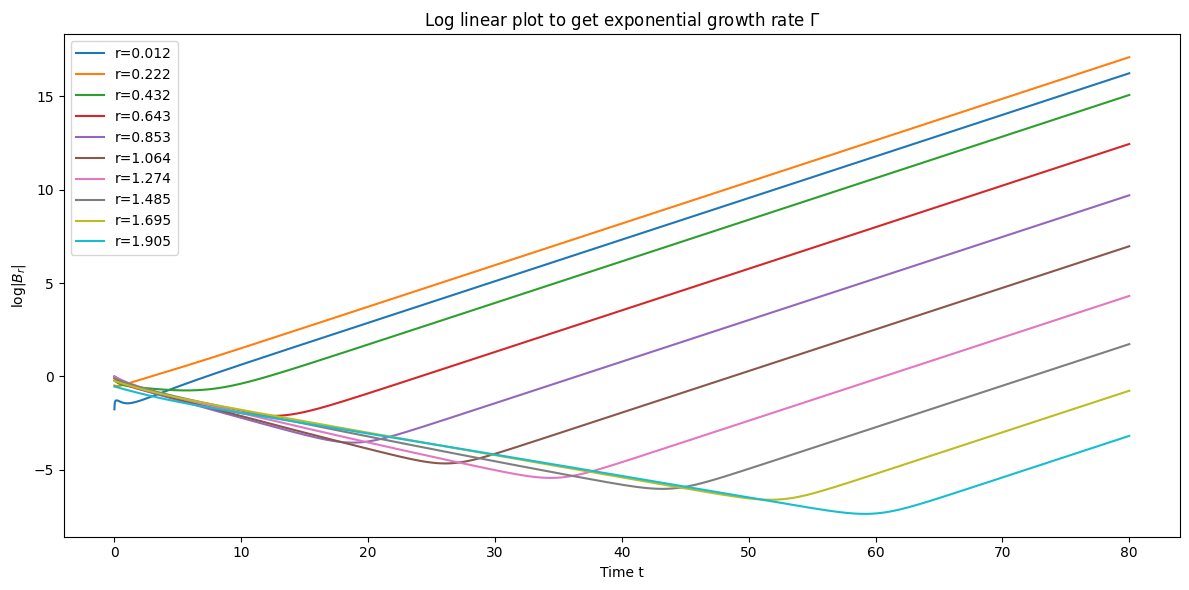

In [21]:
#Decay/Growth Rate of |B_r| vs. t for different alpha0

plot.figure(figsize=(12, 6))
plot.plot(tarray, np.log10(np.abs(sol_array_Br[:, 2::len(r)//10])))
plot.legend([f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
plot.xlabel('Time t')
plot.ylabel(r'log$|B_r|$')
plot.title(r"Log linear plot to get exponential growth rate $\Gamma$")
plot.tight_layout()
plot.savefig('loglinbr.png')
plot.show()

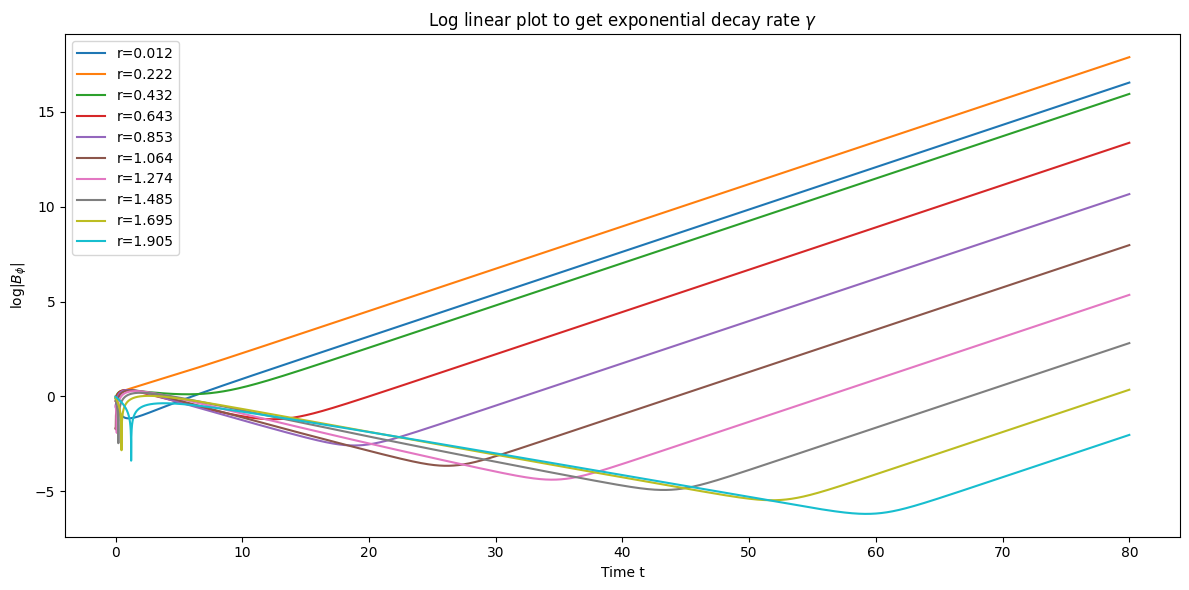

In [22]:
#Decay/Growth Rate of |B_phi| vs. t for different alpha0

plot.figure(figsize=(12, 6))
plot.plot(tarray, np.log10(np.abs(sol_array_Bphi[:, 2::len(r)//10])))
plot.legend([f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
plot.xlabel('Time t')
plot.ylabel(r'log$|B_\phi|$')
plot.title(r"Log linear plot to get exponential decay rate $\gamma$")
plot.tight_layout()
plot.savefig('loglinbphi.png')
plot.show()

In [23]:
#Slope Calculation

#Calculate exp growth at the points,
t1posi=-50
t2posi=-40

#Find slopes (growth rates) at different r values

#Br
slopesBr=[]
for i in range(len(r)):
    slope=(np.log10(np.abs(sol_array_Br[t1posi,i]))-np.log10(np.abs(sol_array_Br[t2posi,i])))/((tarray[t1posi]-tarray[t2posi])*0.43429)
    slopesBr.append(slope)

#Bphi
slopesBphi=[]
for i in range(len(r)):
    slope=(np.log10(np.abs(sol_array_Bphi[t1posi,i]))-np.log10(np.abs(sol_array_Bphi[t2posi,i])))/((tarray[t1posi]-tarray[t2posi])*0.43429)
    slopesBphi.append(slope)

#Btotal
sol_array_tot = sol_array_Br + sol_array_Bphi
slopesBtot=[]
for i in range(len(r)):
    slope=(np.log10(np.abs(sol_array_tot[t1posi,i]))-np.log10(np.abs(sol_array_tot[t2posi,i])))/((tarray[t1posi]-tarray[t2posi])*0.43429)
    slopesBtot.append(slope)

C:\Users\asus\AppData\Local\Temp\ipykernel_16332\3741235373.py:12: RuntimeWarning: divide by zero encountered in log10
  slope=(np.log10(np.abs(sol_array_Br[t1posi,i]))-np.log10(np.abs(sol_array_Br[t2posi,i])))/((tarray[t1posi]-tarray[t2posi])*0.43429)
C:\Users\asus\AppData\Local\Temp\ipykernel_16332\3741235373.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  slope=(np.log10(np.abs(sol_array_Br[t1posi,i]))-np.log10(np.abs(sol_array_Br[t2posi,i])))/((tarray[t1posi]-tarray[t2posi])*0.43429)
C:\Users\asus\AppData\Local\Temp\ipykernel_16332\3741235373.py:18: RuntimeWarning: divide by zero encountered in log10
  slope=(np.log10(np.abs(sol_array_Bphi[t1posi,i]))-np.log10(np.abs(sol_array_Bphi[t2posi,i])))/((tarray[t1posi]-tarray[t2posi])*0.43429)
C:\Users\asus\AppData\Local\Temp\ipykernel_16332\3741235373.py:18: RuntimeWarning: invalid value encountered in scalar subtract
  slope=(np.log10(np.abs(sol_array_Bphi[t1posi,i]))-np.log10(np.abs(sol_array_Bphi[t2posi,i])))/((ta

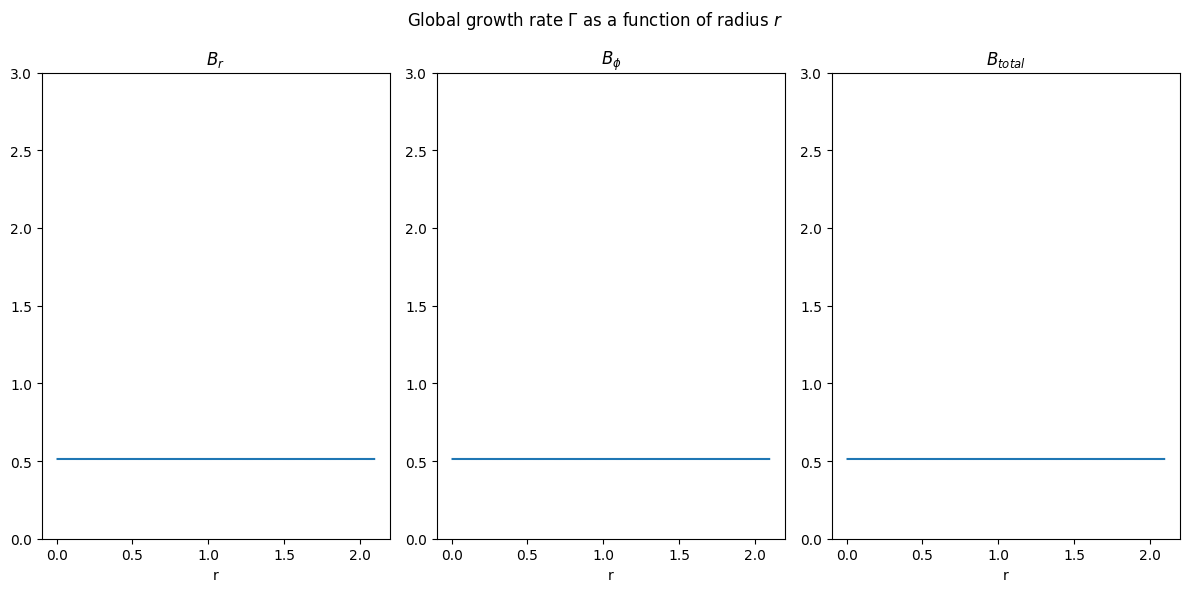

[nan, 0.5130356734866222, 0.5130793585844862, 0.5130268055614479, 0.5130788903113356, 0.513026613571093, 0.5130788093869849, 0.5130265688259288, 0.5130787847907535, 0.5130265535950357, 0.5130787753610002, 0.5130265473231547, 0.5130787711847562, 0.51302654438777, 0.5130787691173391, 0.5130265428629731, 0.5130787679904842, 0.513026541994801, 0.5130787673204652, 0.5130265414580087, 0.5130787668902135, 0.5130265411007607, 0.5130787665943131, 0.5130265408475992, 0.5130787663784715, 0.5130265406580349, 0.5130787662130372, 0.513026540509778, 0.5130787660809352, 0.5130265403892298, 0.5130787659719408, 0.5130265402881083, 0.5130787658792035, 0.5130265402011991, 0.5130787657986335, 0.5130265401249234, 0.5130787657271635, 0.5130265400567253, 0.5130787656628507, 0.5130265399948664, 0.5130787656041614, 0.5130265399380175, 0.5130787655499709, 0.5130265398853607, 0.5130787654994613, 0.5130265398360782, 0.5130787654519169, 0.5130265397896584, 0.5130787654072353, 0.5130265397454881, 0.5130787653644964,

In [24]:
fig, axs = plot.subplots(1, 3, figsize=(12, 6))

axs[0].plot(r,slopesBr)
axs[0].set(ylim=(0,3))
axs[0].set_title(r'$B_r$')

axs[1].plot(r,slopesBphi)
axs[1].set(ylim=(0,3)) 
axs[1].set_title(r'$B_\phi$')

axs[2].plot(r,slopesBtot)
axs[2].set(ylim=(0,3))
axs[2].set_title(r'$B_{total}$')

axs[0].set(xlabel='r')
axs[1].set(xlabel='r')
axs[2].set(xlabel='r')

plot.suptitle(r"Global growth rate $\Gamma$ as a function of radius $r$")
plot.tight_layout()
plot.show()

print(slopesBr)
print(slopesBphi)
print(slopesBtot)

Finally, plot the spatial evolution of $|B_r|$ and $|B_\phi|$, and the pitch angle p for different $\alpha_0$. We can see that the boundary conditions ensure the field is zero at $r=0$ and $r=R_0$.

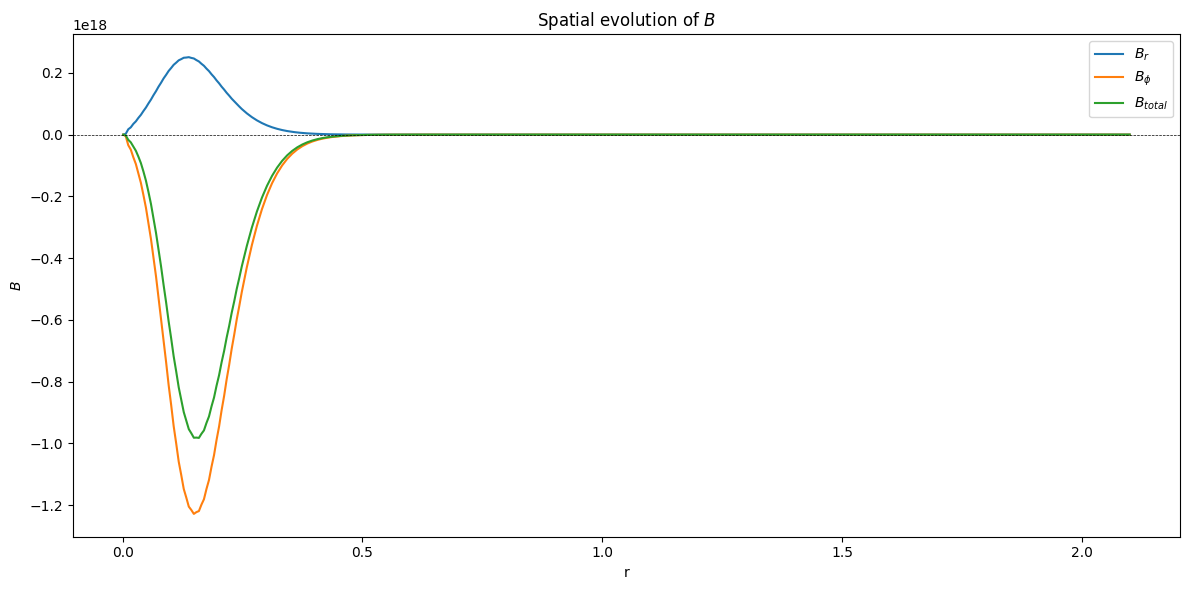

In [25]:
#Spatial evolution of B_i

fig, ax = plot.subplots(figsize=(12, 6))
plot.plot(r, sol_array_Br[-1, :].T)
plot.plot(r, sol_array_Bphi[-1, :].T)
plot.plot(r, sol_array_tot[-1,:].T)
ax.legend(labels = [r'$B_r$', r'$B_\phi$', r'$B_{total}$'])
ax.axhline(y=0, linestyle='--', linewidth=0.5, color='black')
plot.xlabel('r')
plot.ylabel(r'$B$')
plot.title(r"Spatial evolution of $B$")
plot.tight_layout()
plot.savefig('spatial1.png')
plot.show()

brval = np.max(sol_array_Br[-1,:])
bphival = np.min(sol_array_Bphi[-1,:])

C:\Users\asus\AppData\Local\Temp\ipykernel_16332\4192597978.py:5: RuntimeWarning: invalid value encountered in divide
  plot.plot(r[:], np.arctan(sol_array_Br[-1, :]/sol_array_Bphi[-1, :]).T)


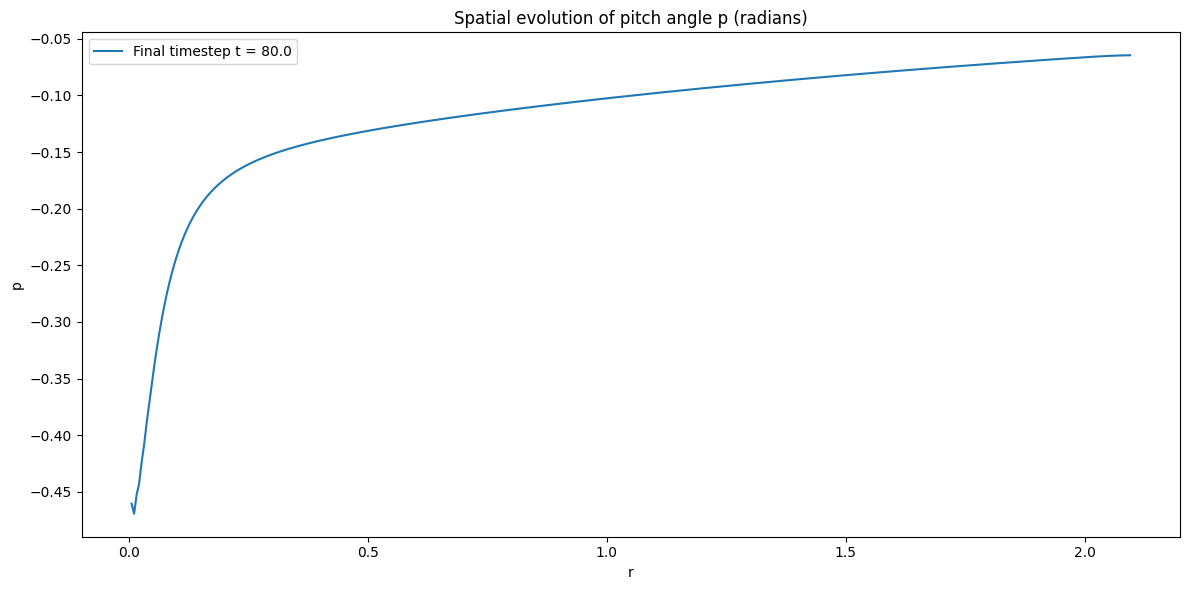

In [26]:
#Pitch Angle

fig, ax = plot.subplots(figsize=(12, 6))
plot.plot(r[:], np.arctan(sol_array_Br[-1, :]/sol_array_Bphi[-1, :]).T)
ax.legend(labels=[f"Final timestep t = {tarray[-1]}"]) 
plot.xlabel('r')
plot.ylabel('p')
plot.title(r"Spatial evolution of pitch angle p (radians)")
plot.tight_layout()
plot.show()

In [30]:
#Outputs

# Define the file path
file_path = "output1.txt"

# Open the file in write mode
with open(file_path, "w") as file:
    # Write the output data to the file
    file.write(str(np.min(D)))
    file.write("\n")
    file.write(str(D))
    file.write("\n")
    file.write(str(slopesBr))
    file.write("\n")
    file.write(str(slopesBphi))
    file.write("\n")
    file.write(str(slopesBtot))
    file.write("\n")
    file.write(str(np.max(sol_array_Br[-1,:])))
    file.write("\n")
    file.write(str(np.min(sol_array_Bphi[-1,:])))
    file.write("\n")
    file.write(str(np.arctan(sol_array_Br[-1, :]/sol_array_Bphi[-1, :]).T))

C:\Users\asus\AppData\Local\Temp\ipykernel_16332\4060421054.py:26: RuntimeWarning: invalid value encountered in divide
  file.write(str(np.arctan(sol_array_Br[-1, :]/sol_array_Bphi[-1, :]).T))
